In [1]:
# DF-Net Imports
from collections import defaultdict
import cv2
from itertools import islice
from multiprocessing.pool import ThreadPool as Pool
from pathlib import Path
import torch.nn.functional as F
import tqdm

# Imports
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from pytorch_metric_learning import losses, samplers
from random import randint
from skimage import io, transform
import time
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data.sampler import Sampler
from torchvision import datasets, models, transforms

ERROR:root:The testing module requires faiss. You can install the GPU version with the command 'conda install faiss-gpu -c pytorch' 
                        or the CPU version with 'conda install faiss-cpu -c pytorch'. Learn more at https://github.com/facebookresearch/faiss/blob/master/INSTALL.md


In [2]:
from sklearn.manifold import TSNE

def map_features(outputs, labels, out_file):
    # create array of column for each feature output
    feat_cols = ['feature'+str(i) for i in range(outputs.shape[1])]
    # make dataframe of outputs -> labels
    df = pd.DataFrame(outputs, columns=feat_cols)
    df['y'] = labels
    df['labels'] = df['y'].apply(lambda i: str(i))
    # clear outputs and labels
    outputs, labels = None, None
    # creates an array of random indices from size of outputs
    np.random.seed(42)
    rndperm = np.random.permutation(df.shape[0])
    num_examples = 3000
    df_subset = df.loc[rndperm[:num_examples],:].copy()
    data_subset = df_subset[feat_cols].values
    tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
    tsne_results = tsne.fit_transform(data_subset)
    df_subset['tsne-2d-one'] = tsne_results[:,0]
    df_subset['tsne-2d-two'] = tsne_results[:,1]
    plt.figure(figsize=(16,10))
    plt.scatter(
        x=df_subset["tsne-2d-one"],
        y=df_subset["tsne-2d-two"],
        c=df_subset["y"],
        s=3
    )
    plt.savefig(out_file, bbox_inches='tight', pad_inches = 0)
    plt.close()

In [3]:
# Configurations
# Device
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# Num epochs
num_epochs = 5

# Model 
model = models.resnet50()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Batch size
batch_size = 32

# Data set
train_path = '/lab/vislab/DATA/CUB/images/'

# Loss function
criterion = losses.TripletMarginLoss(margin=0.1)

In [4]:
class RandomMask(object):
    """Add random occlusions to image.

    Args:
        mask: (Image.Image) - Image to use to occlude.
    """

    def __init__(self, mask):
        assert isinstance(mask, Image.Image)
        self.mask = mask

    def __call__(self, sample):                    
        self.mask = self.mask.resize((64,64))
        theta = randint(0,45)
        self.mask = self.mask.rotate(angle=theta)
        seed_x = randint(1,10)
        seed_y = randint(1,10)
        sample.paste(self.mask, (20*seed_x, 20*seed_y))

        return sample

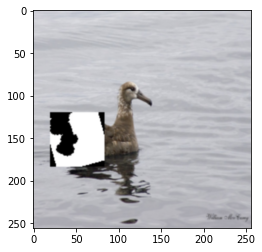

In [8]:
# Dataset

# occlusion transform?
mask = Image.open('./samples/places2/mask/mask_01.png')

transformations = transforms.Compose([
    transforms.Resize((256,256)),
    RandomMask(mask), 
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(train_path, transformations)

plt.imshow(transforms.ToPILImage()(dataset[3][0]), interpolation="bicubic")

# train_set, test_set = torch.utils.data.random_split(dataset, [5000, 1033])

# train_sampler = torch.utils.data.RandomSampler(train_set)
train_sampler = samplers.MPerClassSampler(dataset.targets, 2, len(dataset)) # maybe train set

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                   sampler=train_sampler, num_workers=4)

In [ ]:
# DF-Net Utils

def resize_like(x, target, mode='bilinear'):
    return F.interpolate(x, target.shape[-2:], mode=mode, align_corners=False)


def list2nparray(lst, dtype=None):
    """fast conversion from nested list to ndarray by pre-allocating space"""
    if isinstance(lst, np.ndarray):
        return lst
    assert isinstance(lst, (list, tuple)), 'bad type: {}'.format(type(lst))
    assert lst, 'attempt to convert empty list to np array'
    if isinstance(lst[0], np.ndarray):
        dim1 = lst[0].shape
        assert all(i.shape == dim1 for i in lst)
        if dtype is None:
            dtype = lst[0].dtype
            assert all(i.dtype == dtype for i in lst), \
                'bad dtype: {} {}'.format(dtype, set(i.dtype for i in lst))
    elif isinstance(lst[0], (int, float, complex, np.number)):
        return np.array(lst, dtype=dtype)
    else:
        dim1 = list2nparray(lst[0])
        if dtype is None:
            dtype = dim1.dtype
        dim1 = dim1.shape
    shape = [len(lst)] + list(dim1)
    rst = np.empty(shape, dtype=dtype)
    for idx, i in enumerate(lst):
        rst[idx] = i
    return rst


def get_img_list(path):
    return sorted(list(Path(path).glob('*.png'))) + \
        sorted(list(Path(path).glob('*.jpg'))) + \
        sorted(list(Path(path).glob('*.jpeg')))


def gen_miss(img, mask, output):

    imgs = get_img_list(img)
    masks = get_img_list(mask)
    print('Total images:', len(imgs), len(masks))

    out = Path(output)
    out.mkdir(parents=True, exist_ok=True)

    for i, (img, mask) in tqdm(enumerate(zip(imgs, masks))):
        path = out.joinpath('miss_%04d.png' % (i+1))
        img = cv2.imread(str(img), cv2.IMREAD_COLOR)
        mask = cv2.imread(str(mask), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img.shape[:2][::-1])
        mask = mask[..., np.newaxis]
        miss = img * (mask > 127) + 255 * (mask <= 127)
        cv2.imwrite(str(path), miss)

def merge_imgs(dirs, output, row=1, gap=2, res=512):

    image_list = [get_img_list(path) for path in dirs]
    img_count = [len(image) for image in image_list]
    print('Total images:', img_count) # should be batch size when we walk back into here ... 
    assert min(img_count) > 0, 'Please check the path of empty folder.'

    output_dir = Path(output)
    output_dir.mkdir(parents=True, exist_ok=True)

    n_img = len(dirs)
    row = row
    column = (n_img - 1) // row + 1
    print('Row:', row)
    print('Column:', column)

    for i, unit in tqdm(enumerate(zip(*image_list))):
        name = output_dir.joinpath('merge_%04d.png' % i)
        merge = np.ones([
            res*row + (row+1)*gap, res*column + (column+1)*gap, 3], np.uint8) * 255
        for j, img in enumerate(unit):
            r = j // column
            c = j - r * column
            img = cv2.imread(str(img), cv2.IMREAD_COLOR)
            if img.shape[:2] != (res, res):
                img = cv2.resize(img, (res, res))
            start_h, start_w = (r + 1) * gap + r * res, (c + 1) * gap + c * res
            merge[start_h: start_h + res, start_w: start_w + res] = img
        cv2.imwrite(str(name), merge)

In [ ]:
# DF-Net Model

def get_norm(name, out_channels):
    if name == 'batch':
        norm = nn.BatchNorm2d(out_channels)
    elif name == 'instance':
        norm = nn.InstanceNorm2d(out_channels)
    else:
        norm = None
    return norm


def get_activation(name):
    if name == 'relu':
        activation = nn.ReLU()
    elif name == 'elu':
        activation == nn.ELU()
    elif name == 'leaky_relu':
        activation = nn.LeakyReLU(negative_slope=0.2)
    elif name == 'tanh':
        activation = nn.Tanh()
    elif name == 'sigmoid':
        activation = nn.Sigmoid()
    else:
        activation = None
    return activation


class Conv2dSame(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()

        padding = self.conv_same_pad(kernel_size, stride)
        if type(padding) is not tuple:
            self.conv = nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding)
        else:
            self.conv = nn.Sequential(
                nn.ConstantPad2d(padding*2, 0),
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, 0)
            )

    def conv_same_pad(self, ksize, stride):
        if (ksize - stride) % 2 == 0:
            return (ksize - stride) // 2
        else:
            left = (ksize - stride) // 2
            right = left + 1
            return left, right

    def forward(self, x):
        return self.conv(x)


class ConvTranspose2dSame(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()

        padding, output_padding = self.deconv_same_pad(kernel_size, stride)
        self.trans_conv = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size, stride,
            padding, output_padding)

    def deconv_same_pad(self, ksize, stride):
        pad = (ksize - stride + 1) // 2
        outpad = 2 * pad + stride - ksize
        return pad, outpad

    def forward(self, x):
        return self.trans_conv(x)


class UpBlock(nn.Module):

    def __init__(self, mode='nearest', scale=2, channel=None, kernel_size=4):
        super().__init__()

        self.mode = mode
        if mode == 'deconv':
            self.up = ConvTranspose2dSame(
                channel, channel, kernel_size, stride=scale)
        else:
            def upsample(x):
                return F.interpolate(x, scale_factor=scale, mode=mode)
            self.up = upsample

    def forward(self, x):
        return self.up(x)


class EncodeBlock(nn.Module):

    def __init__(
            self, in_channels, out_channels, kernel_size, stride,
            normalization=None, activation=None):
        super().__init__()

        self.c_in = in_channels
        self.c_out = out_channels

        layers = []
        layers.append(
            Conv2dSame(self.c_in, self.c_out, kernel_size, stride))
        if normalization:
            layers.append(get_norm(normalization, self.c_out))
        if activation:
            layers.append(get_activation(activation))
        self.encode = nn.Sequential(*layers)

    def forward(self, x):
        return self.encode(x)


class DecodeBlock(nn.Module):

    def __init__(
            self, c_from_up, c_from_down, c_out, mode='nearest',
            kernel_size=4, scale=2, normalization='batch', activation='relu'):
        super().__init__()

        self.c_from_up = c_from_up
        self.c_from_down = c_from_down
        self.c_in = c_from_up + c_from_down
        self.c_out = c_out

        self.up = UpBlock(mode, scale, c_from_up, kernel_size=scale)

        layers = []
        layers.append(
            Conv2dSame(self.c_in, self.c_out, kernel_size, stride=1))
        if normalization:
            layers.append(get_norm(normalization, self.c_out))
        if activation:
            layers.append(get_activation(activation))
        self.decode = nn.Sequential(*layers)

    def forward(self, x, concat=None):
        out = self.up(x)
        if self.c_from_down > 0:
            out = torch.cat([out, concat], dim=1)
        out = self.decode(out)
        return out


class BlendBlock(nn.Module):

    def __init__(
            self, c_in, c_out, ksize_mid=3, norm='batch', act='leaky_relu'):
        super().__init__()
        c_mid = max(c_in // 2, 32)
        self.blend = nn.Sequential(
            Conv2dSame(c_in, c_mid, 1, 1),
            get_norm(norm, c_mid),
            get_activation(act),
            Conv2dSame(c_mid, c_out, ksize_mid, 1),
            get_norm(norm, c_out),
            get_activation(act),
            Conv2dSame(c_out, c_out, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.blend(x)


class FusionBlock(nn.Module):
    def __init__(self, c_feat, c_alpha=1):
        super().__init__()
        c_img = 3
        self.map2img = nn.Sequential(
            Conv2dSame(c_feat, c_img, 1, 1),
            nn.Sigmoid())
        self.blend = BlendBlock(c_img*2, c_alpha)

    def forward(self, img_miss, feat_de):
        img_miss = resize_like(img_miss, feat_de)
        raw = self.map2img(feat_de)
        alpha = self.blend(torch.cat([img_miss, raw], dim=1))
        result = alpha * raw + (1 - alpha) * img_miss
        return result, alpha, raw


class DFNet(nn.Module):
    def __init__(
            self, c_img=3, c_mask=1, c_alpha=3,
            mode='nearest', norm='batch', act_en='relu', act_de='leaky_relu',
            en_ksize=[7, 5, 5, 3, 3, 3, 3, 3], de_ksize=[3]*8,
            blend_layers=[0, 1, 2, 3, 4, 5]):
        super().__init__()

        c_init = c_img + c_mask

        self.n_en = len(en_ksize)
        self.n_de = len(de_ksize)
        assert self.n_en == self.n_de, (
            'The number layer of Encoder and Decoder must be equal.')
        assert self.n_en >= 1, (
            'The number layer of Encoder and Decoder must be greater than 1.')

        assert 0 in blend_layers, 'Layer 0 must be blended.'

        self.en = []
        c_in = c_init
        self.en.append(
            EncodeBlock(4, 64, en_ksize[0], 2, None, None)) # changing 4 breaks it
        for k_en in en_ksize[1:]:
            c_in = self.en[-1].c_out
            c_out = min(c_in*2, 512)
            self.en.append(EncodeBlock(
                c_in, c_out, k_en, stride=2,
                normalization=norm, activation=act_en))

        # register parameters
        for i, en in enumerate(self.en):
            self.__setattr__('en_{}'.format(i), en)

        self.de = []
        self.fuse = []
        for i, k_de in enumerate(de_ksize):

            c_from_up = self.en[-1].c_out if i == 0 else self.de[-1].c_out
            c_out = c_from_down = self.en[-i-1].c_in
            layer_idx = self.n_de - i - 1

            self.de.append(DecodeBlock(
                c_from_up, c_from_down, c_out, mode, k_de, scale=2,
                normalization=norm, activation=act_de))
            if layer_idx in blend_layers:
                self.fuse.append(FusionBlock(c_out, c_alpha))
            else:
                self.fuse.append(None)

        # register parameters
        for i, de in enumerate(self.de[::-1]):
            self.__setattr__('de_{}'.format(i), de)
        for i, fuse in enumerate(self.fuse[::-1]):
            if fuse:
                self.__setattr__('fuse_{}'.format(i), fuse)

#     def forward(self, img_miss, mask):
    def forward(self, img_miss):

#         out = torch.cat([img_miss, mask], dim=1)

        # because our out will already have the mask on it
        out = img_miss
        
        out_en = [out]
        for encode in self.en:
            out = encode(out)
            out_en.append(out)

        results = []
        alphas = []
        raws = []
        for i, (decode, fuse) in enumerate(zip(self.de, self.fuse)):
            out = decode(out, out_en[-i-2])
            if fuse:
                result, alpha, raw = fuse(out, out)
                results.append(result)
                alphas.append(alpha)
                raws.append(raw)

        return results[::-1], alphas[::-1], raws[::-1]



In [ ]:
# DF-Net inpaint (from the DF-Net tester)

class Inpainter:

    def __init__(self, model_path, input_size, batch_size):
        self.model_path = model_path
        self._input_size = input_size
        self.batch_size = batch_size
        self.init_model(model_path)

    @property
    def input_size(self):
        if self._input_size > 0:
            return (self._input_size, self._input_size)
        elif 'celeba' in self.model_path:
            return (256, 256)
        else:
            return (512, 512)

    def init_model(self, path):
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
            print('Using gpu.')
        else:
            self.device = torch.device('cpu')
            print('Using cpu.')

        self.model1 = DFNet().to(self.device)
        checkpoint = torch.load(path, map_location=self.device)
        self.model1.load_state_dict(checkpoint)
        self.model1.eval()

        print('Model1 %s loaded.' % path)

    def get_name(self, path):
        return '.'.join(path.name.split('.')[:-1])

    def results_path(self, output, img_path, mask_path, prefix='result'):
        img_name = self.get_name(img_path)
        mask_name = self.get_name(mask_path)
        return {
            'result_path': self.sub_dir('result').joinpath(
                'result-{}-{}.png'.format(img_name, mask_name)),
            'raw_path': self.sub_dir('raw').joinpath(
                'raw-{}-{}.png'.format(img_name, mask_name)),
            'alpha_path': self.sub_dir('alpha').joinpath(
                'alpha-{}-{}.png'.format(img_name, mask_name))
        }

    def inpaint_instance(self, img, mask):
        """Assume color image with 3 dimension. CWH"""
        img = img.view(1, *img.shape)
        mask = mask.view(1, 1, *mask.shape)
        return self.inpaint_batch(img, mask).squeeze()

    def inpaint_batch(self, imgs, masks):
        """Assume color channel is BGR and input is NWHC np.uint8."""
        imgs = np.transpose(imgs, [0, 3, 1, 2])
        masks = np.transpose(masks, [0, 3, 1, 2])

        imgs = torch.from_numpy(imgs).to(self.device)
        masks = torch.from_numpy(masks).to(self.device)
        imgs = imgs.float().div(255)
        masks = masks.float().div(255)
        imgs_miss = imgs * masks
        results = self.model1(imgs_miss, masks)
        if type(results) is list:
            results = results[0]
        results = results.mul(255).byte().data.cpu().numpy()
        results = np.transpose(results, [0, 2, 3, 1])
        return results

    def _process_file(self, output, img_path, mask_path):
        item = {
            'img_path': img_path,
            'mask_path': mask_path,
        }
        item.update(self.results_path(output, img_path, mask_path))
        self.path_pair.append(item)

    def process_single_file(self, output, img_path, mask_path):
        self.path_pair = []
        self._process_file(output, img_path, mask_path)

    def process_dir(self, output, img_dir, mask_dir):
        img_dir = Path(img_dir)
        mask_dir = Path(mask_dir)
        imgs_path = sorted(
            list(img_dir.glob('*.jpg')) + list(img_dir.glob('*.png')))
        masks_path = sorted(
            list(mask_dir.glob('*.jpg')) + list(mask_dir.glob('*.png')))

        n_img = len(imgs_path)
        n_mask = len(masks_path)
        n_pair = min(n_img, n_mask)

        self.path_pair = []
        for i in range(n_pair):
            img_path = imgs_path[i % n_img]
            mask_path = masks_path[i % n_mask]
            self._process_file(output, img_path, mask_path)

    def get_process(self, input_size):
        def process(pair):
            img = cv2.imread(str(pair['img_path']), cv2.IMREAD_COLOR)
            mask = cv2.imread(str(pair['mask_path']), cv2.IMREAD_GRAYSCALE)
            if input_size:
                img = cv2.resize(img, input_size)
                mask = cv2.resize(mask, input_size)
            img = np.ascontiguousarray(img.transpose(2, 0, 1)).astype(np.uint8)
            mask = np.ascontiguousarray(
                np.expand_dims(mask, 0)).astype(np.uint8)

            pair['img'] = img
            pair['mask'] = mask
            return pair
        return process

    def _file_batch(self):
        pool = Pool()

        n_pair = len(self.path_pair)
        n_batch = (n_pair-1) // self.batch_size + 1

        for i in tqdm.trange(n_batch, leave=False):
            _buffer = defaultdict(list)
            start = i * self.batch_size
            stop = start + self.batch_size
            process = self.get_process(self.input_size)
            batch = pool.imap_unordered(
                process, islice(self.path_pair, start, stop))
            for instance in batch:
                for k, v in instance.items():
                    _buffer[k].append(v)
            yield _buffer

#     def batch_generator(self):
#         generator = self._file_batch

#         for _buffer in generator():
#             for key in _buffer:
#                 if key in ['img', 'mask']:
#                     _buffer[key] = list2nparray(_buffer[key])
#             yield _buffer

    def to_numpy(self, tensor):
        tensor = tensor.mul(255).byte().data.cpu().numpy()
        tensor = np.transpose(tensor, [0, 2, 3, 1])
        return tensor

    def process_batch(self, batch, output):
#         imgs = torch.from_numpy(batch['img']).to(self.device)
#         masks = torch.from_numpy(batch['mask']).to(self.device)
#         imgs = imgs.float().div(255)
#         masks = masks.float().div(255)

        # so we wantt  change our tensors to numpy
    
    
    #### what does this do? ####
        # imgs_miss = imgs * masks
        
        ## occluded_imgs = batch[0...32] ##

        ## So the model needs the separate mask ##
        # result is the one we care about
        
        ## maybe the model also has to be init? ##
        
        print(batch.shape)
        
        time.sleep(10)
        
        result, alpha, raw = self.model1(batch)
        result, alpha, raw = result[0], alpha[0], raw[0]
        result = imgs * masks + result * (1 - masks)

        result = self.to_numpy(result)
        result = torch.from_numpy(result)
        
        
#         alpha = self.to_numpy(alpha)
#         raw = self.to_numpy(raw)

#         for i in range(batch.shape[0]):
#             cv2.imwrite(str(batch['result_path'][i]))
#         for i in range(result.shape[0]):
#             cv2.imwrite(str(batch['result_path'][i]), result[i])
#             cv2.imwrite(str(batch['raw_path'][i]), raw[i])
#             cv2.imwrite(str(batch['alpha_path'][i]), alpha[i])
            
        return result

    @property
    def root(self):
        return Path(self.output)

    def sub_dir(self, sub):
        return self.root.joinpath(sub)

    def prepare_folders(self, folders):
        for folder in folders:
            Path(folder).mkdir(parents=True, exist_ok=True)

    def inpaint(self, output, batch, merge_result=True):

        # so we get passed in a batch with already occluded images
        
        self.output = output
        self.prepare_folders([
            self.sub_dir('result'), self.sub_dir('alpha'),
            self.sub_dir('raw')])

        # okay, so img is a torch batch tensor now:
        
#         if os.path.isfile(img) and os.path.isfile(mask):
#             if img.endswith(('.png', '.jpg', '.jpeg')):
#                 self.process_single_file(output, img, mask)
#                 _type = 'file'
#             else:
#                 raise NotImplementedError()
#         elif os.path.isdir(img) and os.path.isdir(mask):
#             self.process_dir(output, img, mask)
#             _type = 'dir'
#         else:
#             print('Img: ', img)
#             print('Mask: ', mask)
#             raise NotImplementedError(
#                 'img and mask should be both file or directory.')

        print('# Inpainting...')
        print('Input size:', self.input_size)
        
        modified_batch = []
        for image in batch:
            m = self.process_batch(image, output)
            modified_batch.append(m)
#         modified_batch = self.process_batch(batch, output)
        print('Inpainting finished.')

#         if merge_result and _type == 'dir':
#             miss = self.sub_dir('miss')
#             merge = self.sub_dir('merge')

#             print('# Preparing input images...')
#             gen_miss(img, mask, miss)
#             print('# Merging...')
#             merge_imgs([
#                 miss, self.sub_dir('raw'), self.sub_dir('alpha'),
#                 self.sub_dir('result'), img], merge, res=self.input_size[0])
#             print('Merging finished.')
            
            
        return modified_batch 

In [6]:
# Main Trainer
def train_model():
    """Generic function to train model"""

    start_time = datetime.now()
    correct = 0 
    incorrect = 0 
    num_batches = 0
    loss_values = []

    # DF-Net Tester Instantiate
#     pretrained_model_path = './model/model_places2.pth'
#     inpainter = Inpainter(pretrained_model_path, 256, 8)

    # Epochs 
    for epoch in range(num_epochs): 
        print("epoch num:", epoch)
        
        running_outputs = torch.FloatTensor().cpu()
        running_labels = torch.LongTensor().cpu()
        running_loss = 0.0
        model.train()
                                
        # Batches
        for batch_idx, (inputs, labels) in enumerate(train_loader): 
            
            # *** put the DF-Net call here on this call, NOT THE OTHER LOOP ***
            
            # they should already be masked
            # inputs is a batch of 32 images, can access just like: inputs[31]
            
#             inpainted_img_batch = inpainter.inpaint('output/', inputs, merge_result=True)
            
            num_batches += 1
            optimizer.zero_grad()

            inputs, labels = inputs.to(device), labels.to(device)
            output = model.forward(inputs)
            
           
            loss = criterion(output, labels)
            loss = Variable(loss, requires_grad = True)

            loss.backward()
            optimizer.step()
            
            running_outputs = torch.cat((running_outputs, output.cpu().detach()), 0)
            running_labels = torch.cat((running_labels, labels.cpu().detach()), 0)

            
            running_loss += loss.item()

        # Accuracy
        for idx, emb in enumerate(running_outputs):    
            pairwise = torch.nn.PairwiseDistance(p=2).to(device)
            dist = pairwise(emb, running_outputs)
            closest = torch.topk(dist, 2, largest=False).indices[1]
            if running_labels[idx] == running_labels[closest]:
                correct += 1
            else:
                incorrect += 1

        print(running_loss / num_batches)
        print("Correct", correct)
        print("Incorrect", incorrect)

        # t-SNE
        map_features(running_outputs, running_labels, "outfile")
        # Loss Plot            
        loss_values.append(running_loss / num_batches)

        time_elapsed = datetime.now() - start_time 
        print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))    

    plt.plot(loss_values)    
    return model, running_loss

In [9]:
# Run Script
model.to(device)

# perhaps parameterize the train model to take in our pre-processed data

trained_model, loss = train_model()
print(loss)

epoch num: 0


IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib64/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib64/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib64/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib64/python3.7/site-packages/torch/utils/data/dataset.py", line 257, in __getitem__
    return self.dataset[self.indices[idx]]
IndexError: list index out of range


In [ ]:
# Test Script

print(type(trained_model))
trained_model.test()

print("Finished.")

In [ ]:
# Debug cell
train_sampler = torch.utils.data.RandomSampler(train_set)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                       sampler=train_sampler, num_workers=4)

for batch_idx, (inputs, labels) in enumerate(train_loader): 
    print(batch_idx)
    print(type(inputs))
    # plot
#     plt.imshow(transforms.ToPILImage()(inputs[31]), interpolation="bicubic")
    print(inputs.shape)
    
    break

In [ ]:
# # DF-Net Train Loop 
# def train_dfnet():
#     """Generic function to train model"""
    
#     print("Training model ...")

#     start_time = datetime.now()
#     loss_values = []
#     num_batches = 0 
    
#     # Epochs 
#     for epoch in range(num_epochs): 
#         print("epoch num:", epoch)
#         train_sampler = torch.utils.data.RandomSampler(train_set)
#         train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
#                                                sampler=train_sampler, num_workers=4)
       
#         running_outputs = torch.FloatTensor().cpu()
#         running_labels = torch.LongTensor().cpu()
#         running_loss = 0.0
#         dfnet_model.train()
        
#         # Batches
#         for batch_idx, (inputs, labels) in enumerate(train_loader):  
                        
#             num_batches += 1
#             optimizer.zero_grad()

#             inputs, labels = inputs.to(device), labels.to(device)
#             output = dfnet_model.forward(inputs)
            
#             running_outputs = torch.cat((running_outputs, output.cpu().detach()), 0)
#             running_labels = torch.cat((running_labels, labels.cpu().detach()), 0)

#             loss = criterion(output, labels)
#             loss = Variable(loss, requires_grad = True)
            
#             loss.backward()
#             optimizer.step()
            
#             running_loss += loss.item()

#         # Loss Plot            
#         loss_values.append(running_loss / num_batches)

#         time_elapsed = datetime.now() - start_time 
#         print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))    

#     plt.plot(loss_values)    
#     return dfnet_model, running_loss

In [ ]:
# # DF-Net outputs
# # TODO: implement this
# # but how can we parameterize thi?

# def inpaint(): 
#     running_outputs = torch.FloatTensor().cpu()
#     running_labels = torch.LongTensor().cpu()
#     running_loss = 0.0  
    
#     dfnet_sampler = torch.utils.data.RandomSampler(test_set)
#     dfnet_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
#                                            sampler=dfnet_sampler, num_workers=4)
    
#     with torch.no_grad():        
#         for data, labels in dfnet_loader:
#             data, labels = data.to(device), labels.to(device)
#             output = model(data)
            
#             running_outputs = torch.cat((running_outputs, output.cpu().detach()), 0)
#             running_labels = torch.cat((running_labels, labels.cpu().detach()), 0)
    
#             loss = criterion(output, labels)
#             running_loss += loss.item()

            
    
#     print(type(output))
#     print(output.shape)
#     print(type(output[0][0]))
    
#     return output

In [ ]:
# Testing
def test():
    trained_model.eval()
    test_running_outputs = torch.FloatTensor().cpu()
    test_running_labels = torch.LongTensor().cpu()
    test_running_loss = 0.0    
    correct = 0 
    incorrect = 0 
    
    test_sampler = torch.utils.data.RandomSampler(test_set)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
                                           sampler=test_sampler, num_workers=4)
    
    with torch.no_grad():        
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            output = trained_model(data)
            
            test_running_outputs = torch.cat((test_running_outputs, output.cpu().detach()), 0)
            test_running_labels = torch.cat((test_running_labels, labels.cpu().detach()), 0)
    
            test_loss = criterion(output, labels)
            test_running_loss += loss.item()

        # Accuracy
        for idx, emb in enumerate(running_outputs.to(device)):    
            pairwise = torch.nn.PairwiseDistance(p=2).to(device)
            dist = pairwise(emb, running_outputs.to(device))
            closest = torch.topk(dist, 2, largest=False).indices[1]
            if running_labels[idx] == running_labels[closest]:
                correct += 1
            else:
                incorrect += 1
                
        map_features(test_running_outputs, test_running_labels, "test_outfile")        
        print("correct", correct)
        print("incorrect", incorrect)

In [ ]:
# # Train DF-Net
# dfnet_model.to(device)
# dfnet_model, loss = train_dfnet()

# print(loss)